# MeDAL Dataset (50 context) - Preprocessing and Model Training with GloVe + LSTM + Self-Attention


This notebook presents a full pipeline for training a neural network model on the MeDAL dataset, focusing on medical abbreviation disambiguation. The key steps include:
- Ensuring reproducibility and loading project configurations.
- Loading and preprocessing the MeDAL dataset splits (train, valid) using a whitespace tokenizer (can be adjusted as per your choice).
- Extracting context windows of 50 words—specifically, 25 words to the left and 25 to the right of each abbreviation instance.
- Saving tokenized context windows as `.parquet` files for efficient access.
- Building a custom vocabulary from training data (with a minimum frequency threshold) and initializing GloVe embeddings.
- Implementing a `LazyEmbeddingDataset` for efficient data loading and embedding lookup.
- Training a hybrid LSTM + Multi-Head Self-Attention model with residual connections, attention-based summarization, and contextual features.
- Leveraging a reusable ModelTrainer class for training and evaluation, including training visualizations.


This setup provides a solid foundation for experimenting with different embedding strategies and model architectures for medical abbreviation expansion tasks.

#### Import libraries

In [1]:
%load_ext autoreload
%autoreload 2
%run ../setup.py

from src.data.medal import MeDALSubset
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import yaml
from src.models.trainer import ModelTrainer
from src.models.factory import ModelFactory
from src.vectorizer.trainable import TrainableEmbedding
from src.vectorizer.glove_embeddings import GloVeEmbedding
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
from env import ProjectPaths
from src.utils import save_embeddings_to_file
import pyarrow.parquet as pq
import numpy as np
import random
import torch.nn as nn
import json

# random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Environment set up: sys.path updated, working dir set to project root.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prashanthjaganathan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prashanthjaganathan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


#### Download and load the dataset

In [2]:
medal_dataset = MeDALSubset('MeDAL')
data, train_data, val_data, test_data = medal_dataset.load_dataset()
class_to_idx = medal_dataset.class_to_idx
del data, val_data, train_data, test_data

MeDAL dataset initialized with name: MeDAL
Dataset already exists at: /Users/prashanthjaganathan/Desktop/CS6120 - NLP/pretaining-language-models-for-medical-text/dataset/medal
Dataset CSVs found in: dataset/medal/pretrain_subset
Total number of classes: 22555


#### Load configurations

In [5]:
%load_ext autoreload
%autoreload 2

def load_config(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)

config = load_config('config/config.yaml')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Tokenize train and valid sets using whitespace tokenizer and store in `.parquet` file

In [ ]:
tokens_and_locations = medal_dataset.tokenize('whitespace', splits=['train'])
contexts = medal_dataset.extract_context_from_tokens(
    tokens_and_locations,
    context_window=config['datasets']['medal']['context_window'])
contexts_df = pd.DataFrame({
    'ABSTRACT_ID': medal_dataset.train_data['ABSTRACT_ID'],
    'CONTEXT': contexts})
contexts_df.head()

# Save as a Parquet file
dir = ProjectPaths.DATASET_DIR.value / 'medal' / 'whitespace_tokenized_subset'
dir.mkdir(parents=True, exist_ok=True)
file_name = dir / "train.parquet"
contexts_df.to_parquet(file_name)
print('Parquet file saved successfully!')


In [ ]:
tokens_and_locations = medal_dataset.tokenize('whitespace', splits=['valid'])
contexts = medal_dataset.extract_context_from_tokens(
    tokens_and_locations,
    context_window=config['datasets']['medal']['context_window'])
contexts_df = pd.DataFrame({
    'ABSTRACT_ID': medal_dataset.val_data['ABSTRACT_ID'],
    'CONTEXT': contexts})
contexts_df.head()

# Save as a Parquet file
dir = ProjectPaths.DATASET_DIR.value / 'medal' / 'whitespace_tokenized_subset'
dir.mkdir(parents=True, exist_ok=True)
file_name = dir / "valid.parquet"
contexts_df.to_parquet(file_name)
print('Parquet file saved successfully!')


In [3]:
train_tokens = pd.read_parquet("dataset/medal/whitespace_tokenized_subset/train.parquet", engine="pyarrow").squeeze()

# to make it as a list[list[str]]
tokenized_train_corpus = [context.tolist() for context in tqdm(train_tokens['CONTEXT'], 'Docs', len(train_tokens['CONTEXT']))] 
print(f'Number of documents in train corpus: {len(tokenized_train_corpus)}')

Docs: 100%|██████████| 3000000/3000000 [00:04<00:00, 689918.14it/s]

Number of documents in train corpus: 3000000


#### Create vocabulary from the train set

In [6]:
from collections import Counter

min_word_freq = 2
counter = Counter()
# tokenized_train_corpus is a list of tuples: (list_of_tokens, abbreviation)
for tokens in tokenized_train_corpus:
    counter.update(tokens)

external_vocab = {"<PAD>": 0, "<UNK>": 1}
for token, freq in counter.items():
    if freq >= min_word_freq:
        external_vocab[token] = len(external_vocab)

print(f"External vocab size: {len(external_vocab)}")



External vocab size: 490968


In [7]:
config_glove = config['embedding_models']['glove']
config_glove['external_vocab'] = external_vocab  # Pass the external vocabulary

### Model Training

First, let's create the dataloader with embeddings as features and labels.

In [8]:
class LazyEmbeddingDataset(Dataset):
    def __init__(
            self, 
            file_path, 
            embedding_model, 
            labels, 
            class_to_idx, 
            return_tokens=True,
            max_seq_len=None):
        """
        Args:
            file_path (str): Path to the Parquet file containing the tokenized text.
            embedding_model: The custom embedding model (e.g., GloVeEmbedding).
            labels (list): Labels corresponding to each document.
            class_to_idx (dict): Mapping from class label to integer index.
            max_seq_len (int, optional): Max sequence length for padding/truncating.
        """
        self.file_path = file_path
        table = pq.read_table(self.file_path)
        self.tokenized_corpus = table['CONTEXT']  # Assuming the corpus is tokenized in the file
        self.embedding_model = embedding_model
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.max_seq_len = max_seq_len
        self.label_names = set(self.labels)
        self.return_tokens = return_tokens

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Get the tokens for the current document
        tokens = self.tokenized_corpus[idx].as_py()  # Convert PyArrow StringScalar to string

        if self.return_tokens:
            embeddings = self.embedding_model.token_indices(tokens)
        else:
            # Compute the embeddings for this document on the fly using the embedding model
            embeddings = self.embedding_model.embed(tokens)  # shape: (seq_len, embedding_dim)

        # Convert to numpy arrays
        # embeddings = np.array(embeddings, dtype=np.float32)
        seq_len = len(embeddings)
        embedding_dim = self.embedding_model.embedding_dim
        embeddings = embeddings + [0] * (self.max_seq_len - seq_len) if seq_len < self.max_seq_len else embeddings[:self.max_seq_len]

        # Padding/Truncation based on max_seq_len
        # if self.max_seq_len is not None:
        #     if seq_len < self.max_seq_len:
        #         if self.return_tokens:
        #             pad = np.zeros((self.max_seq_len - seq_len), dtype=np.float32)
        #             embeddings = np.concatenate((embeddings, pad), axis=0)
        #         else:
        #             pad = np.zeros((self.max_seq_len - seq_len, embedding_dim), dtype=np.float32)
        #             embeddings = np.vstack([embeddings, pad])
        #     else:
        #         embeddings = embeddings[:self.max_seq_len]

        # Mask to indicate valid tokens
        mask = np.ones(seq_len, dtype=np.float32)
        if self.max_seq_len is not None and seq_len < self.max_seq_len:
            mask = np.concatenate([mask, np.zeros(self.max_seq_len - seq_len, dtype=np.float32)])

        # Convert label to index
        label = self.labels[idx]
        label_idx = self.class_to_idx[label]

        return (torch.tensor(embeddings, dtype=torch.long),
                torch.tensor(mask, dtype=torch.long),  # Return the mask
                torch.tensor(label_idx, dtype=torch.long))


def create_lazy_dataloader(file_path, embedding_model, labels, class_to_idx, batch_size, max_seq_len=None, shuffle=False):
    dataset = LazyEmbeddingDataset(file_path, embedding_model, labels, class_to_idx, max_seq_len=max_seq_len, return_tokens=True)
    return DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        num_workers=0, 
        pin_memory=True
        )
    # return dataset

In [9]:
glove_embedding_model = GloVeEmbedding(**config['embedding_models']['glove'])

max_seq_len = config['datasets']['medal']['max_sequence_length']
batch_size = config['training']['hyperparameters']['batch_size']

trainloader = create_lazy_dataloader(
    'dataset/medal/whitespace_tokenized_subset/train.parquet', 
    glove_embedding_model, 
    medal_dataset.train_data['LABEL'],
    class_to_idx, 
    batch_size=batch_size,
    max_seq_len=max_seq_len,
    shuffle=True
)


valloader = create_lazy_dataloader(
    'dataset/medal/whitespace_tokenized_subset/valid.parquet', 
    glove_embedding_model, 
    medal_dataset.val_data['LABEL'],
    class_to_idx, 
    batch_size=batch_size,
    max_seq_len=max_seq_len,
    shuffle = False
    )

#### Execute training pipeline

In [ ]:
# Use the new dataloaders
model_trainer = ModelTrainer(config_file='config.yaml')
train_results = model_trainer.train(
    trainloader,
    valloader,
    dataset='medal',
    embedding_dim=100,
    embedding_model = glove_embedding_model
)

------- lstm_and_self_attention --------
{'lstm_units': 1, 'lstm_hidden_dim': 128, 'num_attention_heads': 8, 'dropout': 0, 'max_sequence_length': 50, 'num_classes': 22555, 'embedding_dim': 100, 'create_embedding_layer': True, 'embedding_model': <src.vectorizer.glove_embeddings.GloVeEmbedding object at 0x2ac81952e020>}


Training:  21%|██▏       | 10017/46875 [01:30<05:28, 112.04it/s]

[Epoch 1] Batch 10000/46875 - Avg Loss (last 10000): 7.4665


Training:  43%|████▎     | 20015/46875 [03:00<04:01, 111.03it/s]

[Epoch 1] Batch 20000/46875 - Avg Loss (last 10000): 5.9367


Training:  64%|██████▍   | 30021/46875 [04:32<02:29, 112.72it/s]

[Epoch 1] Batch 30000/46875 - Avg Loss (last 10000): 5.7154


Training:  85%|████████▌ | 40011/46875 [06:08<01:01, 111.73it/s]

[Epoch 1] Batch 40000/46875 - Avg Loss (last 10000): 5.5975


validating: 100%|██████████| 15625/15625 [01:36<00:00, 161.41it/s]


Validation Loss: 5.4992, Accuracy: 0.3449, Precision: 0.4740, Recall: 0.3449
Epoch 1/10 - Train Loss: 0.0951, Train Acc: 0.2808, Prec: 0.3177, Recall: 0.2808, Val Acc: 0.3449, Val Prec: 0.4740, Val Recall: 0.3449


Training:  21%|██▏       | 10017/46875 [01:30<05:25, 113.14it/s]

[Epoch 2] Batch 10000/46875 - Avg Loss (last 10000): 5.2106


Training:  43%|████▎     | 20017/46875 [03:00<03:57, 112.94it/s]

[Epoch 2] Batch 20000/46875 - Avg Loss (last 10000): 5.2771


Training:  64%|██████▍   | 30014/46875 [04:31<02:33, 109.64it/s]

[Epoch 2] Batch 30000/46875 - Avg Loss (last 10000): 5.2881


Training:  85%|████████▌ | 40013/46875 [06:02<01:01, 111.53it/s]

[Epoch 2] Batch 40000/46875 - Avg Loss (last 10000): 5.2804


validating: 100%|██████████| 15625/15625 [01:37<00:00, 160.06it/s]


Validation Loss: 5.3558, Accuracy: 0.3646, Precision: 0.4690, Recall: 0.3646
Epoch 2/10 - Train Loss: 0.0823, Train Acc: 0.3708, Prec: 0.4014, Recall: 0.3708, Val Acc: 0.3646, Val Prec: 0.4690, Val Recall: 0.3646


Training:  21%|██▏       | 10021/46875 [01:37<05:42, 107.51it/s]

[Epoch 3] Batch 10000/46875 - Avg Loss (last 10000): 4.8835


Training:  43%|████▎     | 20018/46875 [03:12<04:15, 105.32it/s]

[Epoch 3] Batch 20000/46875 - Avg Loss (last 10000): 4.9353


Training:  64%|██████▍   | 30013/46875 [04:49<02:44, 102.61it/s]

[Epoch 3] Batch 30000/46875 - Avg Loss (last 10000): 4.9567


Training:  85%|████████▌ | 40017/46875 [06:25<01:03, 107.53it/s]

[Epoch 3] Batch 40000/46875 - Avg Loss (last 10000): 4.9554


validating: 100%|██████████| 15625/15625 [01:36<00:00, 162.00it/s]


Validation Loss: 5.1054, Accuracy: 0.3959, Precision: 0.4737, Recall: 0.3959
Epoch 3/10 - Train Loss: 0.0771, Train Acc: 0.4096, Prec: 0.4346, Recall: 0.4096, Val Acc: 0.3959, Val Prec: 0.4737, Val Recall: 0.3959


Training:  21%|██▏       | 10017/46875 [01:36<05:47, 106.08it/s]

[Epoch 4] Batch 10000/46875 - Avg Loss (last 10000): 4.4413


Training:  43%|████▎     | 20019/46875 [03:12<04:30, 99.32it/s] 

[Epoch 4] Batch 20000/46875 - Avg Loss (last 10000): 4.5696


Training:  64%|██████▍   | 30018/46875 [04:48<02:39, 105.63it/s]

[Epoch 4] Batch 30000/46875 - Avg Loss (last 10000): 4.6306


Training:  85%|████████▌ | 40017/46875 [06:23<01:04, 105.64it/s]

[Epoch 4] Batch 40000/46875 - Avg Loss (last 10000): 4.6694


validating: 100%|██████████| 15625/15625 [01:36<00:00, 162.12it/s]


Validation Loss: 5.0754, Accuracy: 0.4053, Precision: 0.4721, Recall: 0.4053
Epoch 4/10 - Train Loss: 0.0718, Train Acc: 0.4501, Prec: 0.4702, Recall: 0.4501, Val Acc: 0.4053, Val Prec: 0.4721, Val Recall: 0.4053


Training:  21%|██▏       | 10021/46875 [01:35<05:49, 105.34it/s]

[Epoch 5] Batch 10000/46875 - Avg Loss (last 10000): 4.1469


Training:  43%|████▎     | 20013/46875 [03:11<04:33, 98.37it/s] 

[Epoch 5] Batch 20000/46875 - Avg Loss (last 10000): 4.2774


Training:  64%|██████▍   | 30014/46875 [04:46<02:38, 106.51it/s]

[Epoch 5] Batch 30000/46875 - Avg Loss (last 10000): 4.3567


Training:  85%|████████▌ | 40016/46875 [06:23<01:04, 106.29it/s]

[Epoch 5] Batch 40000/46875 - Avg Loss (last 10000): 4.3915


validating: 100%|██████████| 15625/15625 [01:36<00:00, 161.46it/s]


Validation Loss: 5.1071, Accuracy: 0.4088, Precision: 0.4637, Recall: 0.4088
Epoch 5/10 - Train Loss: 0.0674, Train Acc: 0.4864, Prec: 0.5034, Recall: 0.4864, Val Acc: 0.4088, Val Prec: 0.4637, Val Recall: 0.4088


Training:  21%|██▏       | 10018/46875 [01:34<05:39, 108.50it/s]

[Epoch 6] Batch 10000/46875 - Avg Loss (last 10000): 3.8790


Training:  43%|████▎     | 20020/46875 [03:08<04:13, 105.89it/s]

[Epoch 6] Batch 20000/46875 - Avg Loss (last 10000): 4.0117


Training:  64%|██████▍   | 30012/46875 [04:43<02:37, 106.93it/s]

[Epoch 6] Batch 30000/46875 - Avg Loss (last 10000): 4.0838


Training:  85%|████████▌ | 40013/46875 [06:18<01:04, 107.06it/s]

[Epoch 6] Batch 40000/46875 - Avg Loss (last 10000): 4.1259


validating: 100%|██████████| 15625/15625 [01:36<00:00, 161.60it/s]


Validation Loss: 5.1691, Accuracy: 0.4117, Precision: 0.4540, Recall: 0.4117
Epoch 6/10 - Train Loss: 0.0632, Train Acc: 0.5252, Prec: 0.5397, Recall: 0.5252, Val Acc: 0.4117, Val Prec: 0.4540, Val Recall: 0.4117


Training:  21%|██▏       | 10013/46875 [01:34<06:02, 101.83it/s]

[Epoch 7] Batch 10000/46875 - Avg Loss (last 10000): 3.6416


Training:  43%|████▎     | 20017/46875 [03:10<04:10, 107.17it/s]

[Epoch 7] Batch 20000/46875 - Avg Loss (last 10000): 3.7553


Training:  64%|██████▍   | 30010/46875 [04:45<02:49, 99.38it/s] 

[Epoch 7] Batch 30000/46875 - Avg Loss (last 10000): 3.8209


Training:  85%|████████▌ | 40020/46875 [06:21<01:04, 106.35it/s]

[Epoch 7] Batch 40000/46875 - Avg Loss (last 10000): 3.8603


validating: 100%|██████████| 15625/15625 [01:36<00:00, 161.96it/s]


Validation Loss: 5.2295, Accuracy: 0.4125, Precision: 0.4459, Recall: 0.4125
Epoch 7/10 - Train Loss: 0.0592, Train Acc: 0.5669, Prec: 0.5803, Recall: 0.5669, Val Acc: 0.4125, Val Prec: 0.4459, Val Recall: 0.4125


Training:  21%|██▏       | 10017/46875 [01:36<05:39, 108.53it/s]

[Epoch 8] Batch 10000/46875 - Avg Loss (last 10000): 3.4543


Training:  43%|████▎     | 20018/46875 [03:11<04:06, 108.87it/s]

[Epoch 8] Batch 20000/46875 - Avg Loss (last 10000): 3.5315


Training:  64%|██████▍   | 30010/46875 [04:46<02:52, 97.85it/s] 

[Epoch 8] Batch 30000/46875 - Avg Loss (last 10000): 3.5754


Training:  85%|████████▌ | 40012/46875 [06:22<01:05, 105.45it/s]

[Epoch 8] Batch 40000/46875 - Avg Loss (last 10000): 3.6065


validating: 100%|██████████| 15625/15625 [01:36<00:00, 162.57it/s]


Validation Loss: 5.3095, Accuracy: 0.4134, Precision: 0.4393, Recall: 0.4134
Epoch 8/10 - Train Loss: 0.0555, Train Acc: 0.6099, Prec: 0.6219, Recall: 0.6099, Val Acc: 0.4134, Val Prec: 0.4393, Val Recall: 0.4134


Training:  21%|██▏       | 10011/46875 [01:34<05:42, 107.63it/s]

[Epoch 9] Batch 10000/46875 - Avg Loss (last 10000): 3.3076


Training:  43%|████▎     | 20019/46875 [03:09<04:17, 104.23it/s]

[Epoch 9] Batch 20000/46875 - Avg Loss (last 10000): 3.3579


Training:  64%|██████▍   | 30011/46875 [04:44<02:36, 107.85it/s]

[Epoch 9] Batch 30000/46875 - Avg Loss (last 10000): 3.3862


Training:  85%|████████▌ | 40014/46875 [06:19<01:08, 99.90it/s] 

[Epoch 9] Batch 40000/46875 - Avg Loss (last 10000): 3.3981


validating: 100%|██████████| 15625/15625 [01:35<00:00, 163.24it/s]


Validation Loss: 5.3512, Accuracy: 0.4133, Precision: 0.4340, Recall: 0.4133
Epoch 9/10 - Train Loss: 0.0526, Train Acc: 0.6474, Prec: 0.6584, Recall: 0.6474, Val Acc: 0.4133, Val Prec: 0.4340, Val Recall: 0.4133


Training:  21%|██▏       | 10015/46875 [01:34<06:00, 102.26it/s]

[Epoch 10] Batch 10000/46875 - Avg Loss (last 10000): 3.2449


Training:  43%|████▎     | 20011/46875 [03:09<04:07, 108.47it/s]

[Epoch 10] Batch 20000/46875 - Avg Loss (last 10000): 3.2488


Training:  64%|██████▍   | 30015/46875 [04:44<02:43, 102.81it/s]

[Epoch 10] Batch 30000/46875 - Avg Loss (last 10000): 3.2524


Training:  85%|████████▌ | 40012/46875 [06:18<01:06, 102.44it/s]

[Epoch 10] Batch 40000/46875 - Avg Loss (last 10000): 3.2595


validating: 100%|██████████| 15625/15625 [01:36<00:00, 162.47it/s]


Validation Loss: 5.3716, Accuracy: 0.4132, Precision: 0.4325, Recall: 0.4132
Epoch 10/10 - Train Loss: 0.0508, Train Acc: 0.6724, Prec: 0.6827, Recall: 0.6724, Val Acc: 0.4132, Val Prec: 0.4325, Val Recall: 0.4132
Model saved at: trained_models/models/medal_glove_simple_lstm_and_self_attention_model_model.pth


#### Visualize the training results

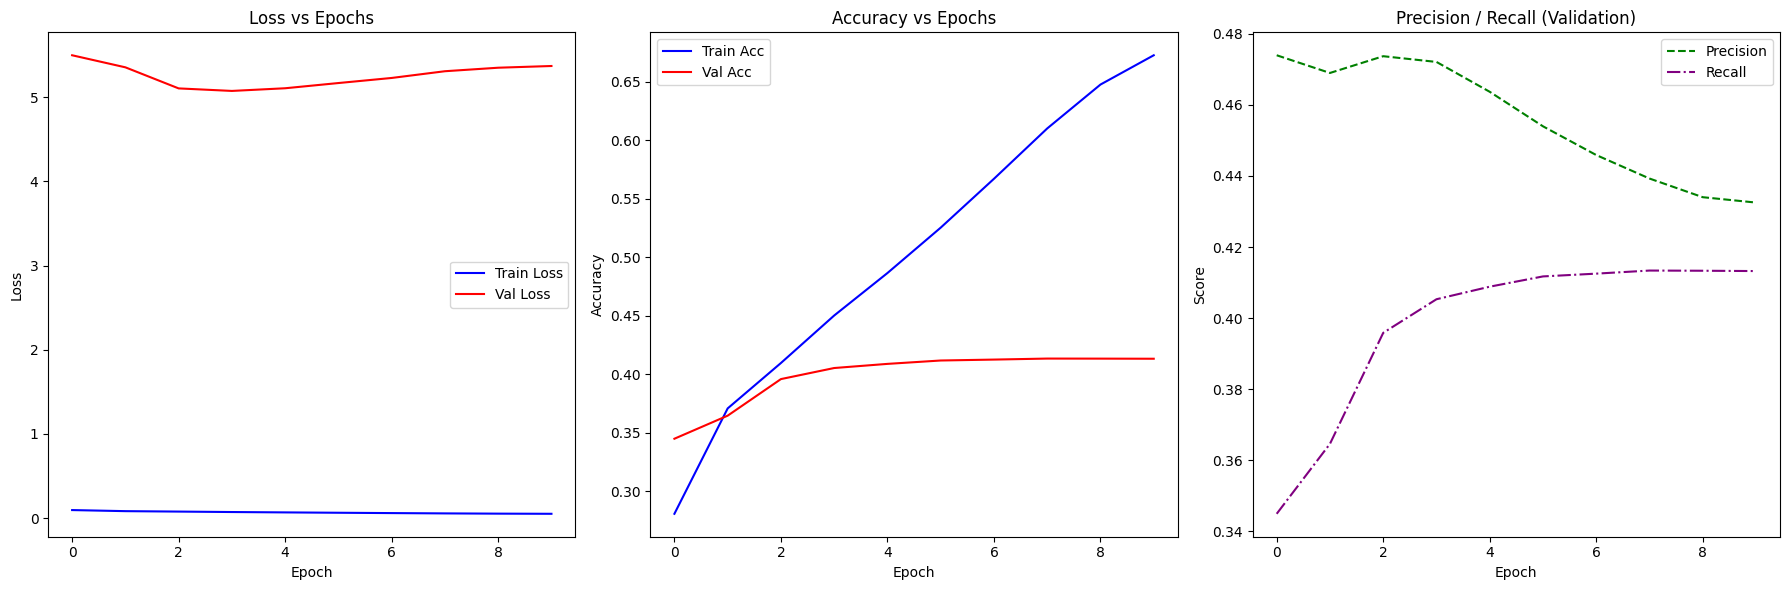

In [13]:
model_trainer.plot_results(train_results)

#### Testing the model

In [10]:
tokens_and_locations = medal_dataset.tokenize('whitespace', splits=['test'])
contexts = medal_dataset.extract_context_from_tokens(
    tokens_and_locations,
    context_window=config['datasets']['medal']['context_window'])
contexts_df = pd.DataFrame({
    'ABSTRACT_ID': medal_dataset.test_data['ABSTRACT_ID'],
    'CONTEXT': contexts})
contexts_df.head()

# Save as a Parquet file
dir = ProjectPaths.DATASET_DIR.value / 'medal' / 'whitespace_tokenized_subset'
dir.mkdir(parents=True, exist_ok=True)
file_name = dir / "test.parquet"
contexts_df.to_parquet(file_name)
print('Parquet file saved successfully!')


Documents: 100%|██████████| 1000000/1000000 [00:33<00:00, 30276.71it/s]


Parquet file saved successfully!


In [11]:
glove_embedding_model = GloVeEmbedding(**config['embedding_models']['glove'])

max_seq_len = config['datasets']['medal']['max_sequence_length']
batch_size = config['training']['hyperparameters']['batch_size']

testloader = create_lazy_dataloader(
    'dataset/medal/whitespace_tokenized_subset/test.parquet', 
    glove_embedding_model, 
    medal_dataset.test_data['LABEL'],
    class_to_idx, 
    batch_size=batch_size,
    max_seq_len=max_seq_len,
    shuffle = False
    )

In [ ]:
model_trainer = ModelTrainer(config_file='config.yaml')
model_name = 'lstm_and_self_attention'
dataset_name = 'medal'
embedding_dim = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

training_hyperparams = config['training']['hyperparameters']
model_hyperparams = config['models'][model_name].get('hyperparameters', {})
model_baseparams = config['models'][model_name].get('base_params', {})
num_classes = config['datasets'][dataset_name]['num_classes']
create_embedding_layer = config['training']['create_embedding_layer']
embedding_model = glove_embedding_model

model_params = {
    **(model_hyperparams if model_hyperparams else {}),
    **(model_baseparams if model_baseparams else {}),
    'num_classes': num_classes,
    'embedding_dim': embedding_dim,
    'create_embedding_layer': create_embedding_layer,
    'embedding_model': embedding_model
}

model_factory = ModelFactory()
model = model_factory.get_model(model_name, **model_params).to(device)
checkpoint_path = 'trained_models/models/medal_glove_simple_lstm_and_self_attention_model_model.pth'
state_dict = torch.load(checkpoint_path, map_location=device)

# NOTE: Make sure the parameters for 'lstm_and_self_attention' in config.yaml 
# match the ones used when the model was originally trained. 
# You can check the training parameters in the first line of the training log.

model.load_state_dict(state_dict)

/Users/prashanthjaganathan/Desktop/CS6120 - NLP/pretaining-language-models-for-medical-text/src/models/model_architectures/lstm_self_attention.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight.data.copy_(torch.tensor(embedding_model.embedding_matrix))


<All keys matched successfully>

In [ ]:
label_smoothing = config.get('label_smoothing', 0.1)
class_weights = None

if 'class_weights' in config['datasets'][dataset_name]:
    with open(config['datasets'][dataset_name]['class_weights'], 'r') as f:
        weights = json.load(f)

    # Convert to torch tensor and move to device
    class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

model_trainer.criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing, weight=class_weights)
test_results = model_trainer.evaluate(
    testloader,
    model
)